In [1]:
using Interact
using LCMGL
using StaticArrays
using CoordinateTransformations
using RigidBodyDynamics

In [2]:
import Flash
reload("Flash")

adding: /home/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/v0.5/DrakeVisualizer/src/lcmtypes to the python path


In [6]:
# Construct the manipulator
arm = Flash.Models.two_link_arm(false);

# Construct the sensor and draw its view rays for debugging
sensor = Flash.DepthSensors.Kinect(41, 41);
camera_origin = SVector(0., 0, 4)
camera_tform = compose(Translation(camera_origin), LinearMap(AngleAxis(pi, 1, 0, 0)))
Flash.DepthSensors.draw_rays(sensor, camera_tform)

state = Flash.ManipulatorState(arm)
Flash.draw(state);

In [7]:
state = Flash.ManipulatorState(arm)
points = Flash.DepthSensors.raycast(state, sensor, camera_tform)
Flash.DepthSensors.draw_points(points)

In [8]:
@manipulate for x1 = linspace(-pi, pi, 101), x2 = linspace(-pi, pi, 101)
    Flash.set_configuration!(state, [x1, x2])
    Flash.draw(state)
    points = Flash.DepthSensors.raycast(state, sensor, camera_tform)
    Flash.DepthSensors.draw_points(points)
end

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"x1",0.0,linspace(-3.141592653589793,3.141592653589793,101),".3f",true)

Interact.Slider{Float64}(Signal{Float64}(0.0, nactions=0),"x2",0.0,linspace(-3.141592653589793,3.141592653589793,101),".3f",true)

nothing

In [9]:
# Difference between two angles, compensating for wraparound
# (taken from angleDiff.m in Drake)
function angle_diff(phi1, phi2)
    mod(phi2 - phi1 + pi, 2*pi) - pi;
end

angle_diff (generic function with 1 method)

In [10]:
using DataFrames, DataArrays
using ForwardDiff

In [11]:
# Now let's try to use the raycast data to recover the joint angles.
# We'll do that by choosing a true (hidden) robot state:
true_state = Flash.ManipulatorState(arm)
Flash.set_configuration!(true_state, [pi, 1.3])
Flash.draw(true_state)

# Now we can raycast that true state to get a set of sensed points:
sensed_points = Flash.DepthSensors.raycast(true_state, sensor, camera_tform)
Flash.DepthSensors.draw_points(sensed_points)

# Our cost function takes the two joint angles and returns the 
# squared sum of the value of the implicit surface at those sensed
# points. If we've recovered the true joint state, then that sum
# should be nearly zero. 
cost = Flash.CostFunctor(arm, sensed_points)

wrapped_cost = x -> begin
    c = cost(x)
    Flash.draw(get(cost.state), false)
    c
end

(::#16) (generic function with 1 method)

In [12]:
cost_and_gradient! = Flash.CostAndGradientFunctor(wrapped_cost)

(::#25) (generic function with 1 method)

In [13]:
trials = []

function test_gradient_descent()
    for i = 1:100
        errors = []
        xs = []
        costs = []

        # We'll initialize our estimate with a uniformly random pair
        # of joint angles
        x_estimated = rand(2) * 2*pi - pi
        g = zeros(x_estimated)

        # Now we use gradient descent to recover the joint angles
        for i = 1:50
            push!(xs, x_estimated)
            push!(errors, norm(angle_diff(x_estimated, true_state.mechanism_state.q)))

            # Evaluate the gradient of the point values w.r.t. the
            # joint angles:
            ci = cost_and_gradient!(g, x_estimated)
            push!(costs, ci)

            if any(isnan, g)
                @show x_estimated
                error("NaN in gradient")
            end

            # Descend the gradient
            step = -ci ./ g
            step = sign(step) .* min.(0.05, abs.(g))
            x_estimated += step
        end
        push!(trials, DataFrame(x=xs, err=errors, cost=costs))
    end
end

test_gradient_descent (generic function with 1 method)

In [14]:
test_gradient_descent()
# trials = []
# Profile.clear
# @time @profile test_gradient_descent()
# ProfileView.view()

Constructing a new state with T: ForwardDiff.Dual{2,Float64}


In [15]:
using Gadfly

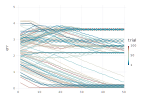

In [16]:
# Now we can plot the progress of each trial

Gadfly.plot([layer(trial, y="err", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials)]..., 
    Guide.colorkey("trial"))

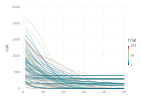

In [17]:
Gadfly.plot([layer(trial, y="cost", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials)]..., 
    Guide.colorkey("trial"))

In [18]:
state = Flash.ManipulatorState(arm)
@manipulate for j = 1:length(trials), i = 1:size(trials[1], 1)
    trial = trials[j]
    set_configuration!(state.mechanism_state, SVector{2, Float64}(trial[:x][i]))
    Flash.draw(state)
    trial[:x][i], trial[:cost][i]
end

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"j",50,1:100,"d",true)

Interact.Slider{Int64}(Signal{Int64}(25, nactions=0),"i",25,1:50,"d",true)

([-0.518605,2.99453],203.4570471196153)

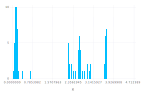

In [19]:
# A histogram of the final cost of each trial shows that most random
# configurations eventually converged to the correct answer (a final
# cost near 0.0), but that some got stuck in local minima

Gadfly.plot(x=[trial[:err][end] for trial in trials], Geom.histogram, Guide.xticks(ticks=collect(0:pi/4:3*pi/2)))

In [20]:
# Now let's repeat the trial, but starting within + or - 0.5 of the true
# joint angles (to simulate running online with a good initial guess).

trials_close = []

for i = 1:100
    errors = []
    xs = []
    costs = []

    # Start within +- 0.5 of x_true
    x_estimated = (rand(2) - 0.5) + true_state.mechanism_state.q
    g = zeros(x_estimated)

    # Now we use gradient descent to recover the joint angles
    for i = 1:50
        push!(xs, x_estimated)
        push!(errors, norm(angle_diff(x_estimated, true_state.mechanism_state.q)))

        # Evaluate the gradient of the point values w.r.t. the
        # joint angles:
        ci = cost_and_gradient!(g, x_estimated)
        push!(costs, ci)

        if any(isnan, g)
            @show x_estimated
            error("NaN in gradient")
        end

        # Descend the gradient
        step = -ci ./ g
        step = (0.95)^i * sign(step) .* min.(0.05, abs.(g))
        x_estimated += step
    end
    push!(trials_close, DataFrame(x=xs, err=errors, cost=costs))
end

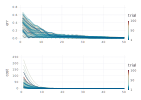

In [21]:
vstack(Gadfly.plot([layer(trial, y="err", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials_close)]..., 
    Guide.colorkey("trial")),
    Gadfly.plot([layer(trial, y="cost", color=i+zeros(size(trial,1)), Geom.line) for (i, trial) in enumerate(trials_close)]..., 
    Guide.colorkey("trial")))

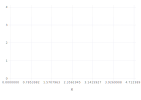

In [22]:
# When starting out reasonably close to the correct configuration, every
# single sample converged to the true joint angles. The histogram confirms:

Gadfly.plot(x=[trial[:err][end] for trial in trials_close], Geom.histogram, Guide.xticks(ticks=collect(0:pi/4:3*pi/2)))

In [23]:
@manipulate for j = 1:length(trials_close), i = 1:size(trials_close[1], 1)
    trial = trials_close[j]
    Flash.set_configuration!(state, SVector{2, Float64}(trial[:x][i]))
    Flash.draw(state)
    trial[:x][i], trial[:cost][i]
end

Interact.Slider{Int64}(Signal{Int64}(50, nactions=0),"j",50,1:100,"d",true)

Interact.Slider{Int64}(Signal{Int64}(25, nactions=0),"i",25,1:50,"d",true)

([3.17939,1.24869],0.24426288037616825)